In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import cv2
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

In [2]:
def convert_y_label_to_string(y, dataset):
    return ''.join([dataset.mapper(int(i)) for i in y])

In [3]:
from text_recognizer.models import TransformerModel
from text_recognizer.datasets import IamLinesDataset

In [4]:
dataset = IamLinesDataset(train=False,
        init_token="<sos>",
        pad_token="_",
        eos_token="<eos>",
        transform=[{"type": "ToTensor", "args": {}}],
        target_transform=[
            {
                "type": "AddTokens",
                "args": {"init_token": "<sos>", "pad_token": "_", "eos_token": "<eos>"},
            }
        ],
    )
dataset.load_or_generate_data()

In [5]:
config_path = "../training/experiments/TransformerModel_IamLinesDataset_CNNTransformer/1116_082932/config.yml"
with open(config_path, "r") as f:
    experiment_config = yaml.safe_load(f)

In [6]:
experiment_config["network"]["type"]

'CNNTransformer'

In [7]:
model = TransformerModel(network_fn=experiment_config["network"]["type"], dataset=experiment_config["dataset"]["type"], dataset_args=experiment_config["dataset"])

2020-11-22 20:36:09.684 | DEBUG    | text_recognizer.models.base:load_weights:432 - Loading network with pretrained weights.


In [121]:
ckpt_path = "../training/experiments/TransformerModel_IamLinesDataset_CNNTransformer/1110_073929/model/best.pt"
model.load_from_checkpoint(ckpt_path)

2020-11-22 22:45:47.919 | DEBUG    | text_recognizer.models.base:load_from_checkpoint:379 - Loading checkpoint...
2020-11-22 22:45:47.920 | DEBUG    | text_recognizer.models.base:load_from_checkpoint:381 - File does not exist {str(checkpoint_path)}


FileNotFoundError: [Errno 2] No such file or directory: '../training/experiments/TransformerModel_IamLinesDataset_CNNTransformer/1110_073929/model/best.pt'

In [120]:
model.eval()

In [111]:
data, target = dataset[11]
sentence = convert_y_label_to_string(target, dataset) 

In [112]:
target.shape

torch.Size([98])

In [115]:
data = data * (data > 0.1)

In [81]:
from torchvision import transforms

In [82]:
ra = transforms.RandomAffine((-1.1, 1.1), scale=(0.8, 1))

In [83]:
data = ra(data)

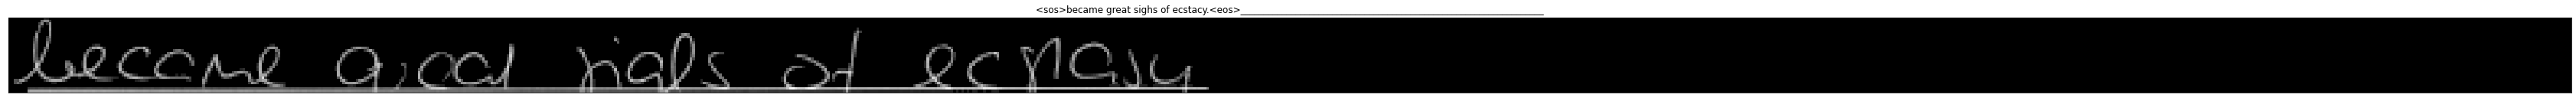

In [116]:
plt.figure(figsize=(60, 20))
plt.title(sentence)
plt.imshow(data.squeeze(0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [119]:
model.predict_on_image(data)

('because droch fis at Caully<eos>', 0.2531574070453644)

In [110]:
data, target = dataset[110]
sentence = convert_y_label_to_string(target, dataset) 

([], [])

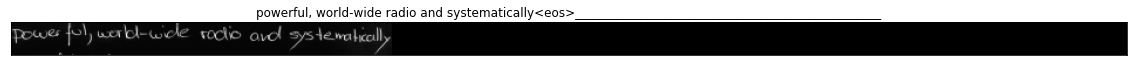

In [111]:
plt.figure(figsize=(20, 20))
plt.title(sentence)
plt.imshow(data.squeeze(0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

In [112]:
model.predict_on_image(data)

('Boyis cheed iitrincy- tarisaing one', 0.3990435302257538)